In [ ]:
# Preamble  here, add paths and import relevant modules
from numpy.random import permutation

%matplotlib inline
import matplotlib, matplotlib.pyplot as plt
from cvxopt import solvers, matrix, spmatrix, sparse, msk, blas, lapack, normal, amd, mul, misc
import sklearn, numpy as np
from sklearn import datasets, neighbors, cluster
from math import sqrt
matplotlib.rcParams['figure.figsize'] = (10,6)

## Generating datasets

0.11


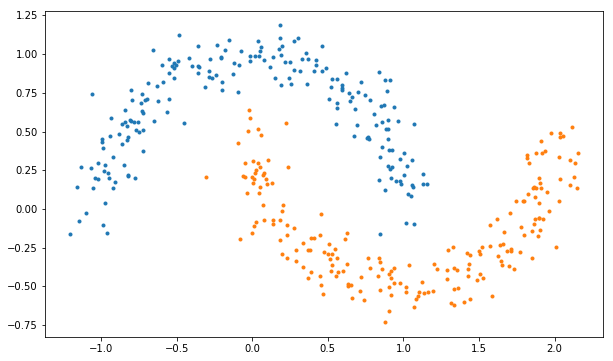

In [77]:
# Two Moons dataset with different noise levels
N = 400
K = 2
x = np.zeros([N,2,5]); y = np.zeros([N,5])
noise = []
plt.figure(1)
for i in range(5):
    noise.append(0.02+.03*(i+1))
    x[:,:,i],y[:,i] = sklearn.datasets.make_moons(N, noise=0.02+.03*(i+1),shuffle = False)

#selecting the most noisy one
sel = 2
X = x[:,:,sel]
y = y[:,sel]
print noise[sel]

for k in range(K):
    plt.plot(X[y==k,0], X[y==k,1], marker='.', color="C"+str(k), lw=0)



## K-means clustering 

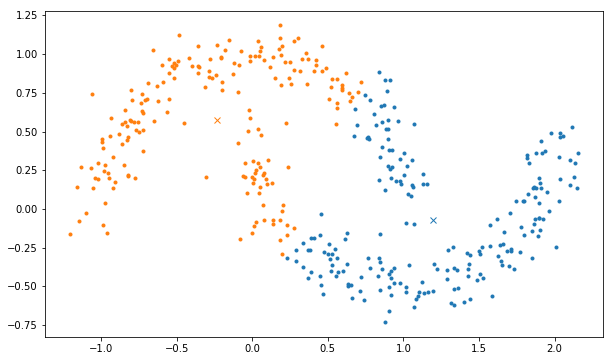

In [78]:
cnt, lbl1, iner = cluster.k_means(X, K)
for k in range(K):
    plt.plot(X[lbl1==k,0], X[lbl1==k,1], marker='.', color="C"+str(k), lw=0)
    plt.plot(cnt[k,0], cnt[k,1], marker='x', color="C"+str(k), lw=0)

## Spectral clustering

In [106]:
#Similarity matrix
m,n = X.shape
S = np.zeros((m,m))
S = np.zeros((X.shape[0],X.shape[0]))
for i in range(m):
  for j in range(m):
    S[i,j] = np.exp(-np.linalg.norm(X[i,:]-X[j,:])**2/(0.1**2*2))

#Laplacian matrix
W = S - np.diag(np.diag(S))
W = sklearn.neighbors.radius_neighbors_graph(X, 0.3, mode='distance') 
D = np.diag(np.sum(W,axis=0))
L = D - W

The first eignvalues are [  4.85722573e-17   8.27761742e-03   4.49923610e-02   4.96725740e-02
   1.49437936e-01   1.77420776e-01]


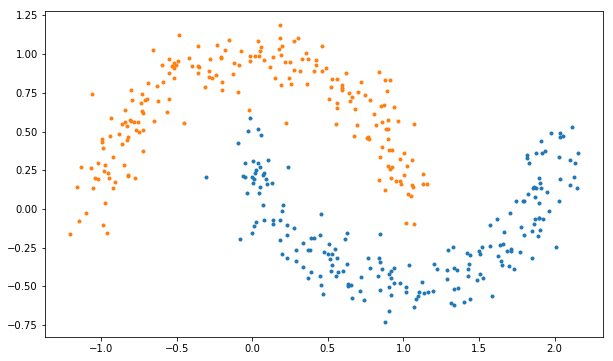

In [101]:
#Spectral clustering
lamb,V = np.linalg.eig(L)
idx = lamb.argsort()
lambOrder = lamb[idx]
VOrder = V[:,idx]
print("The first eignvalues are {}").format(lambOrder[:6])
U = VOrder[:,:K+1]
kmeans = cluster.KMeans(n_clusters=2, random_state=0).fit(U)
label = kmeans.labels_
for k in range(K):
    plt.plot(X[label==k,0],X[label==k,1],marker='.',color='C'+str(k),lw=0)


In [102]:
def custom_kkt(W):
    """
    Custom KKT solver for the following conic LP
    formulation of the Schur relaxation of the
    balance-constrained min/max cut problem
    
        maximize     Tr(C,X)
        subject to 
            X_{ii} = 1, i=1...n
            sum(X) + x = const
            x >= 0, X psd
    """
    
    r = W['rti'][0]
    N = r.size[0]
    e = matrix(1.0,(N,1))
    
    # Form and factorize reduced KKT system
    H = matrix(0.0,(N+1,N+1))
    blas.syrk(r,H,n=N,ldC=N+1)    
    blas.symv(H,e,H,n=N,ldA=N+1,offsety=N,incy=N+1)    
    H[N,N] = blas.dot(H,e,n=N,offsetx=N,incx=N+1)
    rr = H[:N,:N]    # Extract and symmetrize (1,1) block
    misc.symm(rr,N)  # 
    q = H[N,:N].T    # Extract q = rr*e
    H = mul(H,H)
    H[N,N] += W['di'][0]**2
    lapack.potrf(H)
    
    def fsolve(x,y,z):
        """
        Solves the system of equations

            [ 0  G'*W^{-1} ] [ ux ] = [ bx ]
            [ G  -W'       ] [ uz ]   [ bz ]
        
        """
        #  Compute bx := bx + G'*W^{-1}*W^{-T}*bz
        v = matrix(0.,(N,1))
        for i in range(N):
            blas.symv(z,rr,v,ldA=N,offsetA=1,n=N, offsetx = N*i)
            x[i] += blas.dot(rr,v,n=N,offsetx=N*i)
        blas.symv(z,q,v,ldA=N,offsetA=1,n=N)
        x[N] += blas.dot(q,v) + z[0]*W['di'][0]**2
        #  Solve G'*W^{-1}*W^{-T}*G*ux = bx
        lapack.potrs(H,x)
        
        # Compute bz := -W^{-T}*(bz-G*ux)        
        # z -= G*x
        z[1::N+1] -= x[:-1]
        z -= x[-1]
        # Apply scaling
        z[0] *= -W['di'][0]
        blas.scal(0.5,z,n=N,offset=1,inc=N+1) 
        tmp = +r
        blas.trmm(z, tmp, ldA=N, offsetA=1, n=N, m=N)
        blas.syr2k(r, tmp, z, trans='T', offsetC=1, ldC=N, n=N, k=N, alpha = -1.0) 
        
    return fsolve

def balanced_cut_conelp(A, delta = 1.0, cut = 'min'):
    """
    Generates problem data for semidefinite relaxation of the 
    following balance-constrained min/max cut problem
        
        min./max.   -Tr(WX) 
        subject to  X{ii} == 1,  i = 1,...,n
                    sum(X) + x == delta^2
                    x >= 0,  X p.s.d.            
    """
    c = matrix([matrix(-1.0,(N,1)), -delta**2])
    h = matrix([0.0, matrix(A.toarray(),(N**2,1))],(N**2+1,1))
    if cut == 'min': 
        blas.scal(-1.0,h)
    elif not cut == 'max':
        raise ValueError('cut must be "min" or "max"')
    G = sparse([[spmatrix(1.0,[1+i*(N+1) for i in range(N)],range(N),(N**2+1,N))],
                [matrix(1.0,(N**2+1,1))]])
    dims = {'l':1,'q':[],'s':[N]}
    return c,G,h,dims

def balanced_cut(A, delta = 1.0, cut = 'min', solver = "conelp_custom"):
    """
    Solves semidefinite relaxation of the following 
    balance-constrained min/max cut problem
    """
    prob = balanced_cut_conelp(A, delta, cut)
    if solver == "mosek":
        sol = msk.conelp(*prob)
        Z = matrix(sol[2][1:],(N,N),tc='d')
    elif solver == "conelp":
        sol = solvers.conelp(*prob)
        Z = matrix(sol['z'][1:],(N,N),tc='d')
    elif solver == "conelp_custom":
        sol = solvers.conelp(*prob, kktsolver=custom_kkt, options = {'refinement':3})
        Z = matrix(sol['z'][1:],(N,N),tc='d')
    else:
        raise ValueError("Unknown solver")
    return Z

def evd(Z, tol=1e-5, maxr=None, scaled=False):
    """
    Computes eigenvalue decomposition of a symmetrix matrix Z
    and returns a matrix Vr with at most 'maxr' eigenvectors and 
    a vector wr with the corresponding eigenvalues. Only eigenvalues 
    that satisfy lambda_i > tol*lambda_max are included.
    """
    Zt = +Z
    N = Z.size[0]
    if maxr is None: maxr = N
    w = matrix(0.0,(N,1))
    V = matrix(0.0,(N,N))
    lapack.syevr(Zt,w,jobz='V',Z=V)
    if scaled:
        Vr = matrix([[V[:,i]*sqrt(w[i])] for i in range(N-1,N-1-maxr,-1) if w[i] >= tol*w[-1]])
    else:
        Vr = matrix([[V[:,i]] for i in range(N-1,N-1-maxr,-1) if w[i] >= tol*w[-1]])
    wr = matrix([w[i] for i in range(N-1,N-1-maxr,-1) if w[i] >= tol*w[-1]])
    return Vr,wr

In [108]:
Z = balanced_cut(W, delta = 1.0, cut = 'min', solver = 'mosek')

Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 401             
  Cones                  : 0               
  Scalar variables       : 1               
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 401             
  Cones               

('Eigenvalues: ', [375.9080578807109, 24.091942017258457])


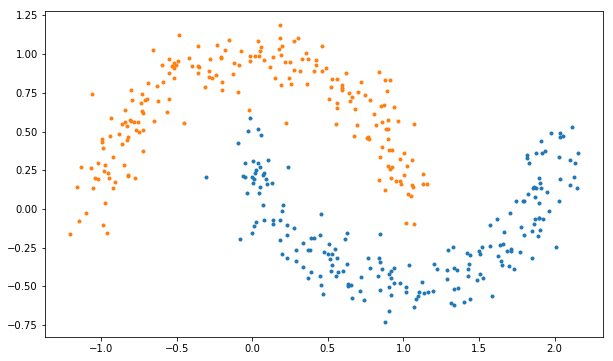

In [124]:
# Compute trunctated EVD
Vr,wr = evd(Z, scaled=True)
print("Eigenvalues: ", list(wr))
# Assign labels and plot 
x1 = np.array([0 if vi >= 0.0 else 1 for vi in list(Vr[:,0])])
for k in range(K):
    plt.plot(X[x1==k,0], X[x1==k,1], marker='.', color="C"+str(k), lw=0)

In [126]:
# Generate 1000 samples and apply rounding 
Am = matrix(W.toarray())
vals = []
fbest = float('-inf')
xbest = None
for k in range(1000):
    x = matrix([-1. if xi >=0 else 1. for xi in Vr*normal(Vr.size[1],1)])
    f = blas.dot(x,Am*x) 
    if f > fbest:
        fbest = f
        xbest = x
    vals.append(f)
print(fbest)

2185.49577068


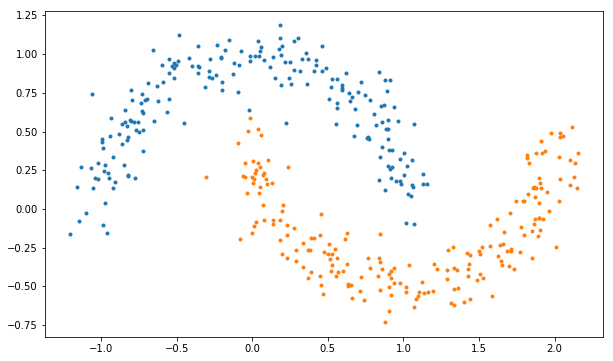

In [127]:
# Assign labels and plot 
x1 = np.array([0 if xi >= 0.0 else 1 for xi in xbest])
for k in range(K):
    plt.plot(X[x1==k,0], X[x1==k,1], marker='.', color="C"+str(k), lw=0)

In [20]:
import cvxpy as cvx
# Problem data.
np.random.seed(1)
#A = numpy.random.randn(m, n)
# Construct the problem.
X = cvx.Semidef(m)
objective = cvx.Minimize(cvx.trace(L*X))
constraints = [X[i,i]==1 for i in range(m)] + [cvx.sum_entries(X)<=1]
#,cvx.sum_entries(x)==0
prob = cvx.Problem(objective,constraints)
print prob.is_dcp()
# The optimal objective is returned by prob.solve().
result = prob.solve(solver='SCS')
# The optimal value for x is stored in x.value.
# The optimal Lagrange multiplier for a constraint
# is stored in constraint.dual_value.
#print constraints[0].dual_value


True


AttributeError: 'numpy.ndarray' object has no attribute 'value'

In [109]:
print X.value

AttributeError: 'numpy.ndarray' object has no attribute 'value'

In [ ]:
lamb, U = np.linalg.eig(X.value)
print U[0]


In [ ]:
print X.value